# Discretization + classification approach to the sqptn1r task

In [2]:
from ay_torch import *
import os

In [3]:
from cnn_sqptn1r_1 import SqPtn1rDataset
root='data_generated/sqptn1r/'

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        # torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='eval':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        #torchvision.transforms.Resize(256),
        #torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(200),
        #torchvision.transforms.RandomResizedCrop(224),
        # torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor()
      ])

In [81]:
dset_train= SqPtn1rDataset(root=root, transform=GetDataTransforms('train'), train=True)
dset_test= SqPtn1rDataset(root=root, transform=GetDataTransforms('eval'), train=False)
#NOTE: Adjust the batch and epoch sizes.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

class TDiscretizer(object):
  def __init__(self, xmin, xmax, n_div):
    self.xmin, self.xmax, self.n_div= xmin, xmax, n_div
    self.dx= (xmax-xmin)/n_div
    self.ptcls_max= torch.tensor(self.n_div-1)
    self.ptcls_min= torch.tensor(0)
  def NumClasses(self):  return self.n_div
  def Encode(self, x):  
    if isinstance(x,torch.Tensor):
      return torch.minimum(self.ptcls_max,torch.maximum(self.ptcls_min,torch.floor((x-self.xmin)/self.dx))).long()
    return np.minimum(self.n_div-1,np.maximum(0,np.floor((x-self.xmin)/self.dx)))
  def Decode(self, c):
    if isinstance(c, torch.Tensor):
      return (self.xmin+0.5*self.dx)+self.dx*torch.minimum(self.ptcls_max,torch.maximum(self.ptcls_min,c))
    return (self.xmin+0.5*self.dx)+self.dx*np.minimum(self.n_div-1,np.maximum(0,c))

discretizer= TDiscretizer(0., 1., n_div=10)

In [5]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][2])
#print('dset_train[0][0] value:',dset_train[0][0][:,100:110,100:110])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][2])
print('dset_test[0][0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 4000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_train[0] label value: tensor([0.3626])
dset_train[0][0] value range: tensor(0.) tensor(1.)
dset_test size: 2000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 200, 200])
dset_test[0] label value: tensor([0.7494])
dset_test[0][0] value range: tensor(0.) tensor(1.)


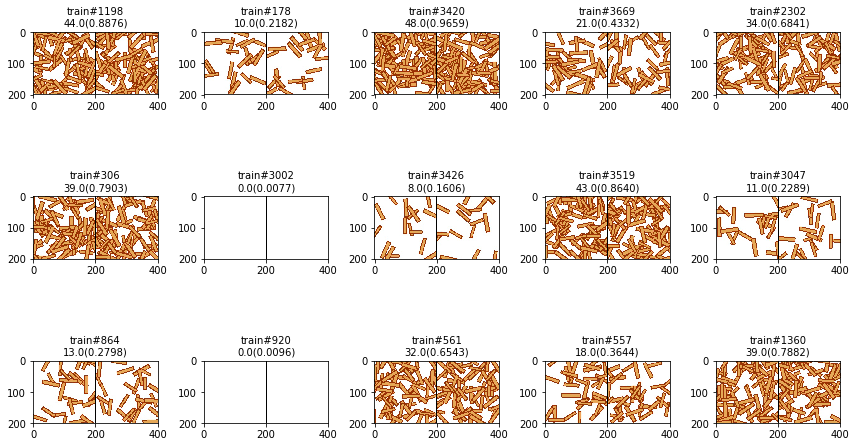

In [6]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [HStackImages(d[i][0],d[i][1]) for i in idxes]
labels= [f'train#{i}\n{discretizer.Encode(d[i][2].item())}({d[i][2].item():.4f})' for i in idxes]
PlotImgGrid(imgs, labels)

# ResNet + ResDenseBlock + ResNetDecoder (Auto Encoder)

In [6]:
#DUPLICATE of cnn_sqptn1r_1

class TResDenseNetWithAE(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, layers=[2, 2, 2, 2], 
               encoder_args=None, decoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=None, n_hiddens2=1, hidden_channels2=None, p_dropout=0.0):
    super(TResDenseNetWithAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    default_decoder_args= {'expansion':1}
    decoder_args= MergeDict(default_decoder_args,decoder_args) if decoder_args else default_decoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=layers, in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_encoder, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
            torch.nn.Dropout(p_dropout) if n_hiddens>0 else TNoop(),
            # torch.nn.Linear(hidden_channels, latent_dim),
            TResDenseBlock(hidden_channels, latent_dim),
            )
    else:
      self.fc_latent= torch.nn.Sequential(
            torch.nn.Flatten(),
            # torch.nn.Linear(ndim_encoder, latent_dim),
            TResDenseBlock(ndim_encoder, latent_dim),
            )
    if hidden_channels2 is not None:
      self.fc_out= torch.nn.Sequential(
            TResDenseBlock(latent_dim*2, hidden_channels2),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels2, hidden_channels2) for i in range(n_hiddens2)],
            torch.nn.Dropout(p_dropout) if n_hiddens2>0 else TNoop(),
            torch.nn.Linear(hidden_channels2, out_channels),
            )
    else:
      self.fc_out= torch.nn.Linear(latent_dim*2, out_channels)
    self.decoder= TResNetDecoder(TResBlock, **decoder_args, layers=layers, in_channels=latent_dim, out_imgshape=in_imgshape)
    InitCNN(self)
  def forward(self, x1, x2):
    x1_encoded,x2_encoded= self.encoder(x1),self.encoder(x2)
    h1,h2= self.fc_latent(x1_encoded),self.fc_latent(x2_encoded)
    y= self.fc_out(torch.cat((h1,h2),1))
    x1_reconstructed,x2_reconstructed= self.decoder(h1),self.decoder(h2)
    return y, x1_reconstructed, x2_reconstructed, h1, h2

class TRDNAELossC(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(TRDNAELossC,self).__init__()
    self.w_xtrg= w_xtrg
  def state_dict(self):
    return {'w_xtrg':self.w_xtrg}
  def load_state_dict(self, d):
    self.w_xtrg= d['w_xtrg']
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y_trg,x1_trg,x2_trg= y_trg
    y_trg= discretizer.Encode(y_trg).reshape(-1)
    if self.w_xtrg==0:
      return torch.nn.functional.cross_entropy(y, y_trg, reduction='mean')
    elif self.w_xtrg==1:
      return torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
    else:
      x_loss= torch.nn.functional.mse_loss(x1_reconstructed, x1_trg)+torch.nn.functional.mse_loss(x2_reconstructed, x2_trg)
      y_loss= torch.nn.functional.cross_entropy(y, y_trg, reduction='mean')
      return self.w_xtrg*x_loss + (1.0-self.w_xtrg)*y_loss

class TRDNAEMetricC(torch.nn.Module):
  def __init__(self):
    super(TRDNAEMetricC,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y,x1_reconstructed,x2_reconstructed,h1,h2= y_pred
    y= discretizer.Decode(y.max(1).indices).reshape(-1,1)
    y_trg,x1_trg,x2_trg= y_trg
    return torch.sqrt(torch.nn.functional.mse_loss(y, y_trg))

In [11]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(),
                        latent_dim=32, hidden_channels2=256, n_hiddens2=3, p_dropout=0.02,
                        layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TRDNAELossC(w_xtrg=0.999)
f_metric= TRDNAEMetricC()

def decode(pred):
  y,x1_reconstructed,x2_reconstructed,h1,h2= pred
  y,x1_reconstructed,x2_reconstructed,h1,h2= y.cpu(),x1_reconstructed.cpu(),x2_reconstructed.cpu(),h1.cpu(),h2.cpu()
  y= discretizer.Decode(y.max(1).indices)
  x1_reconstructed,x2_reconstructed= torch.clamp(x1_reconstructed.cpu(),0,1),torch.clamp(x2_reconstructed.cpu(),0,1)
  return y,x1_reconstructed,x2_reconstructed,h1,h2

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),(y,x1,x2)
logger= TLogger()
disp= TDisp()

In [12]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, depth=7, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNetWithAE                                 --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


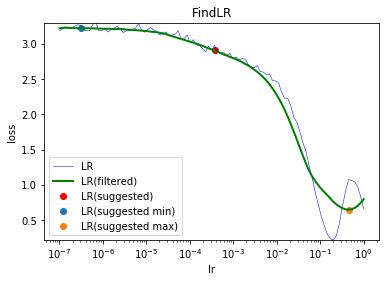

lr= 0.0003715352290971726, lr_min=3.090295432513591e-07, lr_max=0.4466835921509628


In [13]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	2.76584881	3.21207558	0.23640533	0.09979469	 16.117005
1	1.35384136	0.58800463	0.06714147	0.06564176	 16.156459
2	0.24912449	0.15992173	0.05995651	0.04403855	 16.239366
3	0.15953803	0.15753936	0.05090026	0.04372285	 16.232244
4	0.15743438	0.15535174	0.05017618	0.04085946	 16.286898
5	0.15481961	0.15392910	0.04573568	0.04254891	 16.224176
6	0.15316962	0.15161060	0.04502648	0.04287240	 16.234247
7	0.15083484	0.14934429	0.04086121	0.03406304	 16.230178
8	0.14925431	0.14759306	0.03852296	0.04460202	 16.184708
9	0.14741861	0.14767602	0.03514541	0.04812118	 16.260370
10	0.14628373	0.14458040	0.03606556	0.03455530	 16.237457
11	0.14448260	0.14326351	0.03464203	0.03978213	 16.322436
12	0.14354366	0.14360433	0.03196868	0.03162993	 16.293498
13	0.14264589	0.14218868	0.03146029	0.04086176	 16.296143
14	0.14130546	0.14133052	0.02813150	0.02731767	 16.153865
15	0.14082498	0.14131957	0.02781117	0.03782699	 16.246182
16	0.13954334	0.14

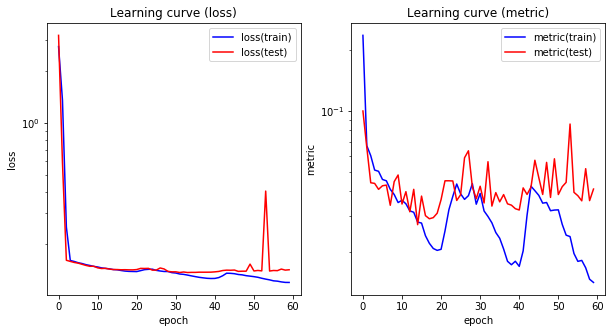

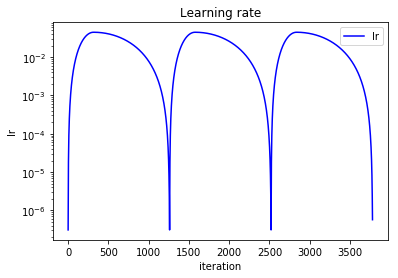

In [14]:
# f_loss.w_xtrg= 0.999
# f_loss.w_xtrg= 0.9
# f_loss.w_xtrg= 0.5
# f_loss.w_xtrg= 0.1
# f_loss.w_xtrg= 0.
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-6,1e-2
# lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,6e-5
# lr_min,lr_max= 1e-7,1e-5
lr_max= lr_max*1e-1
# FreezeParametersExceptFor(net, net.fc_out)
for i in range(3):
  FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

In [ ]:
# f_loss.w_xtrg= 0.9
# FreezeParametersExceptFor(net, net.fc_out)
# FreezeParametersExceptFor(net, (net.fc_latent,net.fc_out))
# FreezeParametersExceptFor(net, (net.encoder,net.fc_latent,net.fc_out))
UnfreezeAllParameters(net)

lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

In [ ]:
# f_loss.w_xtrg= 0.
# FreezeParametersExceptFor(net, net.fc_out)
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
# lr_min,lr_max= 1e-5,1e-3
lr_min,lr_max= 1e-6,3e-4
# lr_min,lr_max= 1e-6,5e-5
# lr_min,lr_max= 1e-7,1e-5
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

In [ ]:
logger.Show('summary')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= decode(Eval(net,(imgs,imgsr),device=device))
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Overfit (latent_dim=32, n_div=50)

    discretizer= TDiscretizer(0., 1., n_div=50)
    net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(),
                            latent_dim=32, hidden_channels2=256, n_hiddens2=3, p_dropout=0.02,
                            layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

total epochs: 60
total time: 13.31min
best loss(train): 0.11898713062206905@59
best loss(test): 0.1358504097443074@33
best metric(train): 0.014134493634282123@59
best metric(test): 0.027317665691953152@14


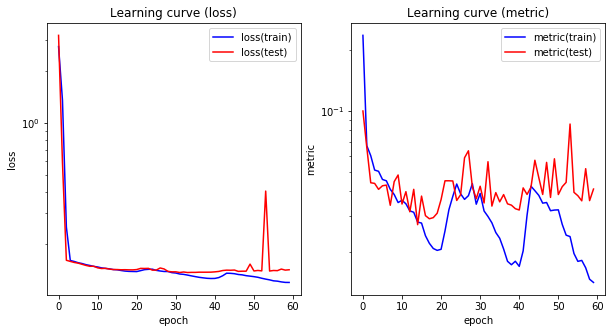

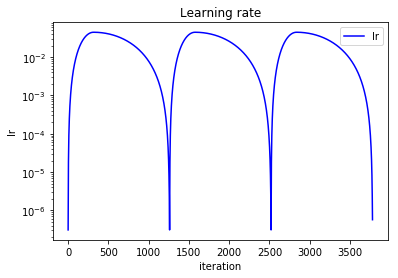

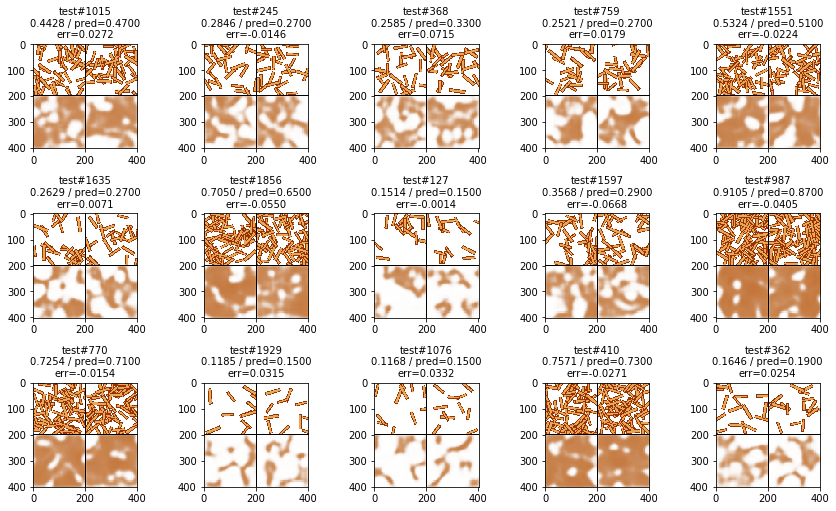

In [15]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= decode(Eval(net,(imgs,imgsr),device=device))
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Overfit (latent_dim=128, n_div=50)

    discretizer= TDiscretizer(0., 1., n_div=50)
    net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(),
                            latent_dim=128, hidden_channels2=256, n_hiddens2=3, p_dropout=0.02,
                            layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

total epochs: 60
total time: 13.32min
best loss(train): 0.10920014173265487@58
best loss(test): 0.12305989349260926@56
best metric(train): 0.007901887224602794@39
best metric(test): 0.03926766448421404@14


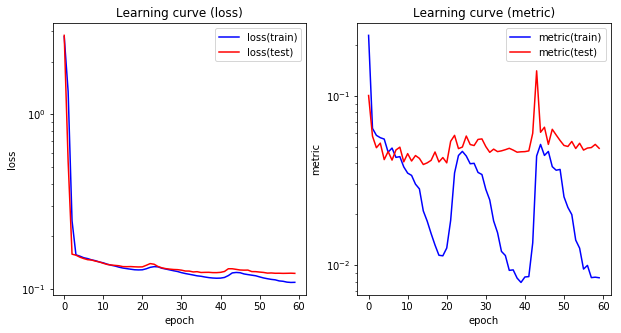

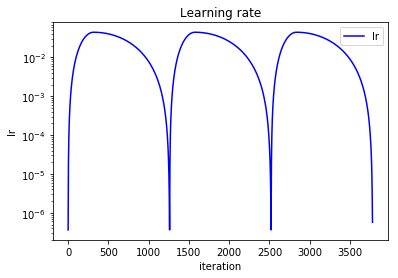

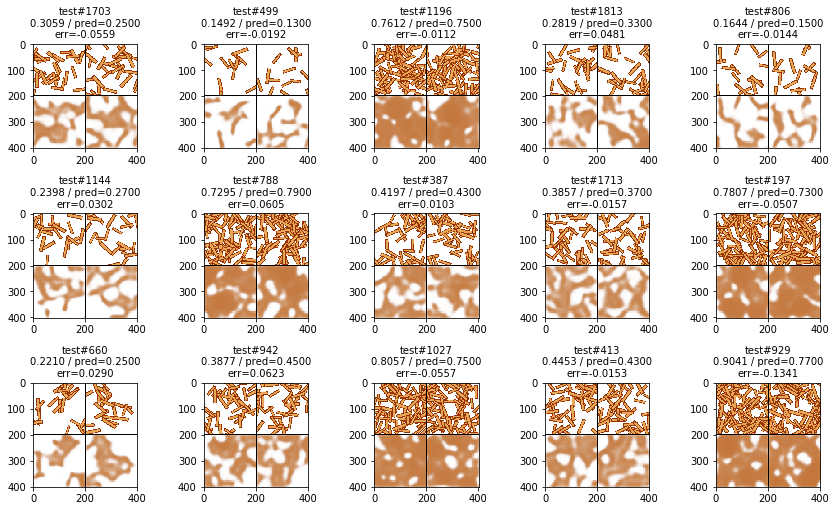

In [10]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= decode(Eval(net,(imgs,imgsr),device=device))
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Overfit (latent_dim=128, n_div=100)

    discretizer= TDiscretizer(0., 1., n_div=100)
    net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(),
                            latent_dim=128, hidden_channels2=256, n_hiddens2=3, p_dropout=0.02,
                            layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

total epochs: 60
total time: 13.41min
best loss(train): 0.10887490425791059@59
best loss(test): 0.12570043350569904@56
best metric(train): 0.0048332802825681274@39
best metric(test): 0.0419129483634606@2


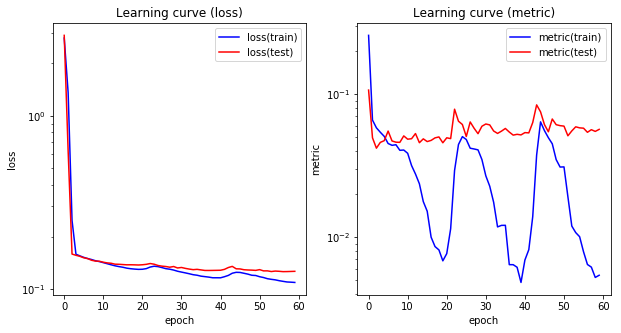

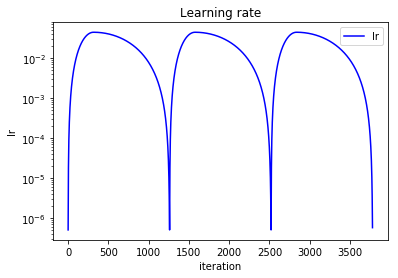

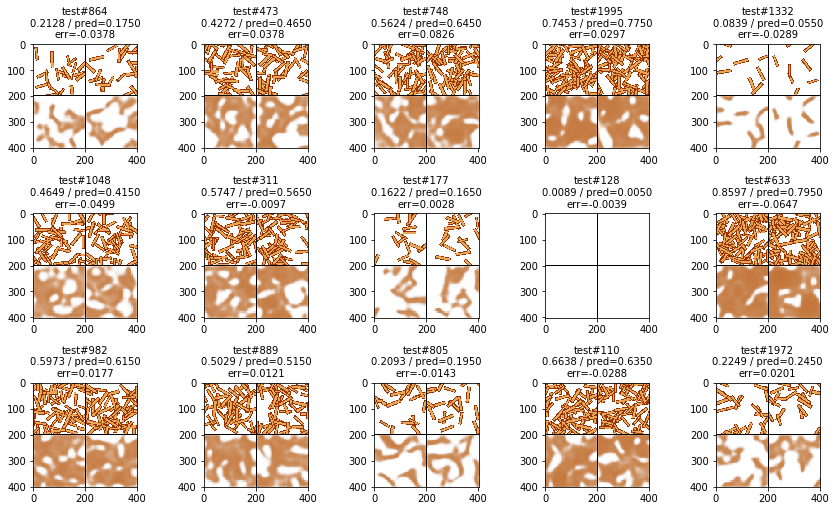

In [40]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= decode(Eval(net,(imgs,imgsr),device=device))
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Overfit (latent_dim=128, n_div=200)

    discretizer= TDiscretizer(0., 1., n_div=200)
    net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(),
                            latent_dim=128, hidden_channels2=256, n_hiddens2=3, p_dropout=0.0,
                            layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

total epochs: 60
total time: 13.33min
best loss(train): 0.10854653954978973@59
best loss(test): 0.13087347149848938@54
best metric(train): 0.0026030767162049575@59
best metric(test): 0.04418793926015496@3


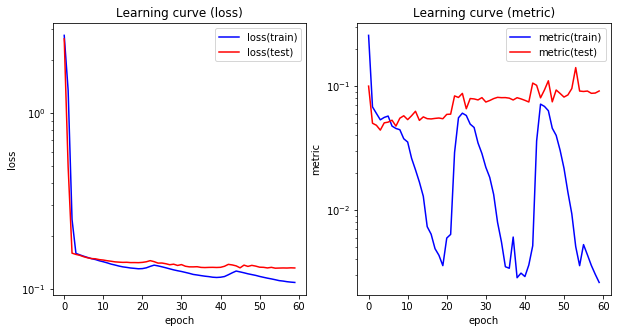

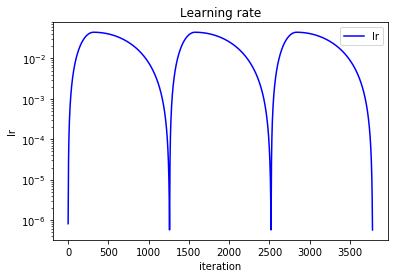

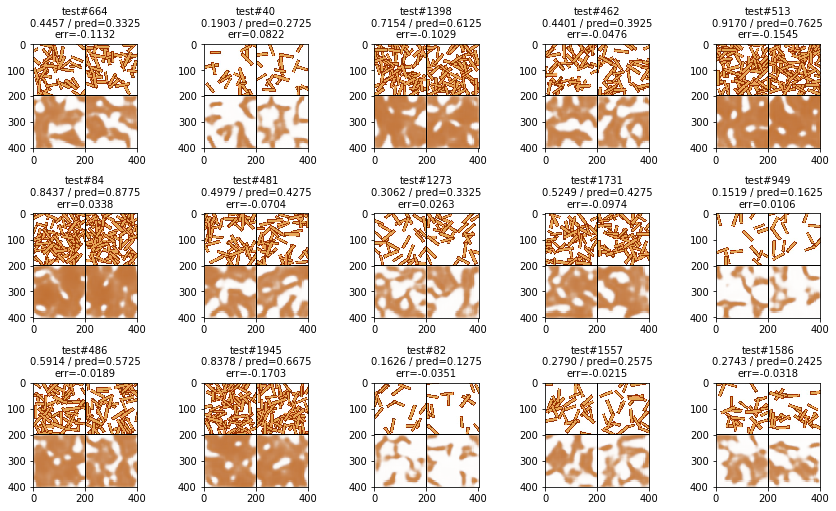

In [28]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= decode(Eval(net,(imgs,imgsr),device=device))
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

## Overfit (latent_dim=256, n_div=200)

    discretizer= TDiscretizer(0., 1., n_div=200)
    net= TResDenseNetWithAE(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(),
                            latent_dim=256, hidden_channels2=256, n_hiddens2=3, p_dropout=0.02,
                            layers=[2, 2, 2, 2], decoder_args=dict(stem_sizes=(64,64,32,32)))

total epochs: 60
total time: 13.33min
best loss(train): 0.10769852108898617@59
best loss(test): 0.12797125475481153@55
best metric(train): 0.007874581262484075@57
best metric(test): 0.03428071329835802@14


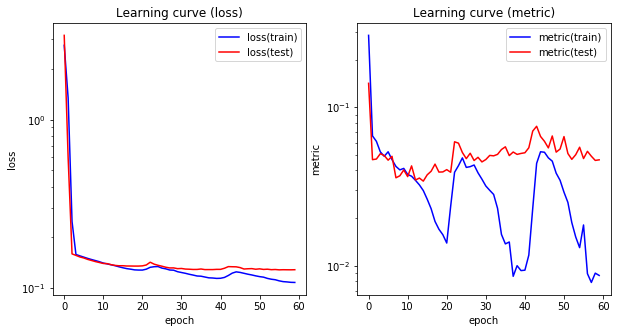

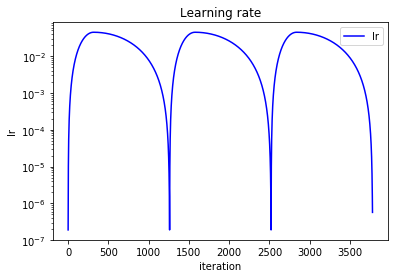

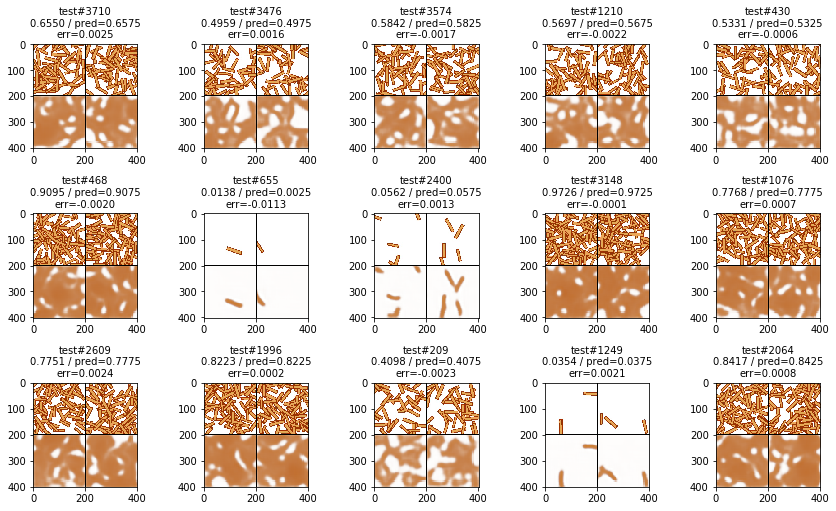

In [19]:
logger.Show('all')
d= dset_train
# d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y,pred_x1,pred_x2,pred_h1,pred_h2= decode(Eval(net,(imgs,imgsr),device=device))
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([VStackImages(HStackImages(img,imgr),HStackImages(x1,x2)) for img,imgr,x1,x2 in zip(imgs,imgsr,pred_x1,pred_x2)], labels)

# ResNet + ResDenseBlock

In [7]:
#DUPLICATE of cnn_sqptn1r_1

class TResDenseNet(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, resnet_args=None,
               n_hiddens=2, hidden_channels=256, p_dropout=0.0):
    super(TResDenseNet,self).__init__()
    default_resnet_args= dict(expansion=1, layers=[2, 2, 2, 2])
    resnet_args= MergeDict(default_resnet_args,resnet_args) if resnet_args else default_resnet_args
    self.resnet= TResNet(TResBlock, **resnet_args, in_channels=in_imgshape[0], with_fc=False)
    ndim_resnet= torch.flatten(self.resnet(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    if hidden_channels is not None:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            TResDenseBlock(ndim_resnet*2, hidden_channels),
            torch.nn.Dropout(p_dropout),
            *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens-1)],
            torch.nn.Dropout(p_dropout) if n_hiddens-1>0 else TNoop(),
            torch.nn.Linear(hidden_channels, out_channels),
            )
    else:
      self.fc= torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(ndim_resnet*2, out_channels),
            )
    InitCNN(self)
  def forward(self, x1, x2):
    x= torch.cat((self.resnet(x1),self.resnet(x2)),1)
    return self.fc(x)

In [24]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResDenseNet(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses())

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return discretizer.Decode(pred.max(1).indices)

class cross_entropy(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(cross_entropy,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y_trg= discretizer.Encode(y_trg).reshape(-1)
    return torch.nn.functional.cross_entropy(y_pred, y_trg, reduction='mean')
f_loss= cross_entropy()

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(decode(y).reshape(-1,1),y_trg))
f_metric= rmse

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),y
logger= TLogger()
disp= TDisp()

In [14]:
# net
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResDenseNet                                       --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


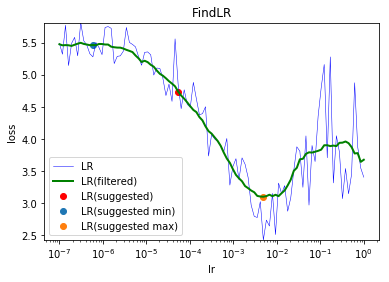

lr= 5.3703179637025284e-05, lr_min=5.888436553555889e-07, lr_max=0.0048977881936844644


In [22]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	3.77861859	2.69793841	0.20154995	0.06138520	 12.707750
1	2.14871521	4.86026585	0.05573546	0.09282122	 12.768607
2	1.68433320	6.89537598	0.05223441	0.14547118	 12.754220
3	0.97749181	3.98004325	0.04099684	0.08156661	 12.806407
4	0.56321737	4.43429622	0.02983792	0.09018668	 12.728250
5	0.20583018	4.43413021	0.01646901	0.08550543	 12.859114
6	0.07151461	4.00685690	0.00831725	0.06800510	 12.881174
7	0.02619166	4.21796513	0.00597002	0.06697655	 12.895672
8	0.01633769	4.25890590	0.00584039	0.06906784	 12.893445
9	0.01066938	4.28722552	0.00578459	0.06917469	 12.835125
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
10	0.01225354	4.30009098	0.00580451	0.06797826	 12.812680
11	0.03425528	4.58483669	0.00631963	0.08376280	 12.764143
12	0.14511196	4.55070450	0.01030046	0.08134824	 12.837777
13	0.57306581	10.38201201	0.03407537	0.16028140	 12.789056
14	1.05319598	3.75797427	0.04061332	0.06317887	 12.933420
15	0.231899

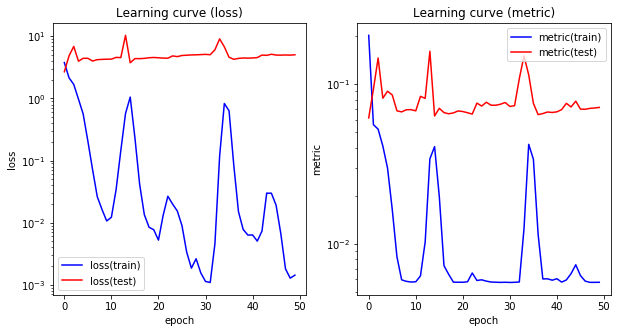

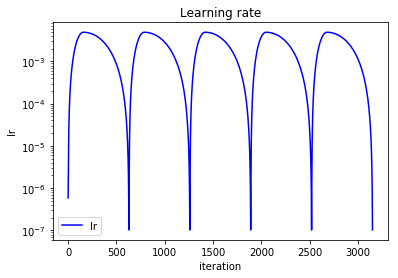

In [25]:
# lr_min/=2;lr_max/=2
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

total epochs: 50
total time: 8.31min
best loss(train): 0.0010925405996016389@31
best loss(test): 2.697938412427902@0
best metric(train): 0.0057493032931926705@30
best metric(test): 0.061385203851386905@0


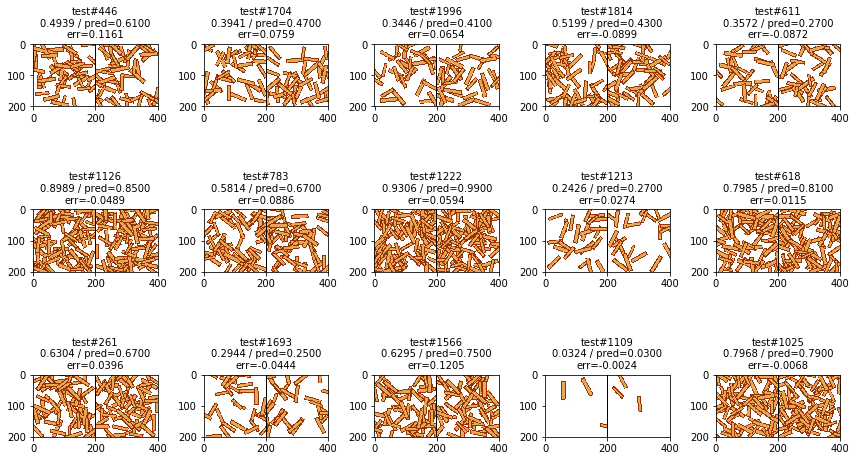

In [27]:
logger.Show('summary')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= decode(Eval(net,(imgs,imgsr),device=device).cpu())
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

## Overfit (TResDenseNet, n_div=50)

total epochs: 50
total time: 8.31min
best loss(train): 0.0010925405996016389@31
best loss(test): 2.697938412427902@0
best metric(train): 0.0057493032931926705@30
best metric(test): 0.061385203851386905@0


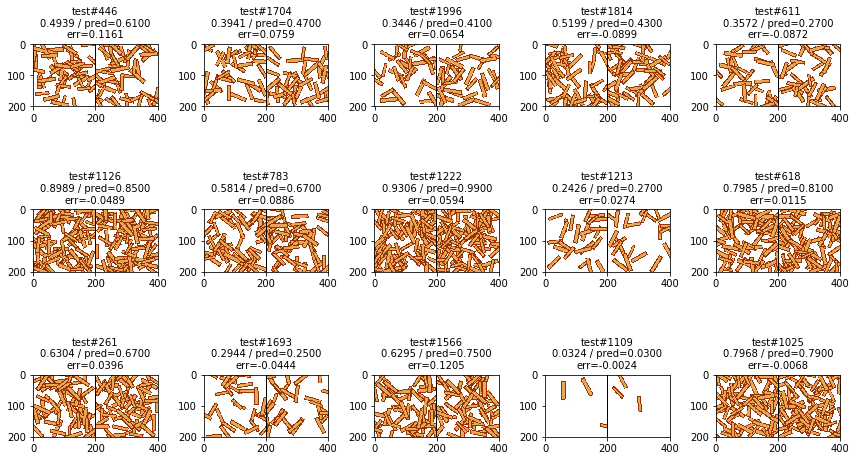

In [27]:
logger.Show('summary')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= decode(Eval(net,(imgs,imgsr),device=device).cpu())
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

# ResNet-18

In [82]:
class TResNet18_2(torch.nn.Module):
  def __init__(self, in_imgshape, out_channels, p_dropout=0.0):
    super(TResNet18_2,self).__init__()
    self.resnet= TResNet18(in_channels=in_imgshape[0], with_fc=False, p_dropout=p_dropout)
    self.fc_flatten= torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(output_size=1), 
            torch.nn.Flatten()
            )
    ndim_resnet= self.fc_flatten(self.resnet(torch.zeros((3,)+tuple(in_imgshape)))).shape[1]
    self.fc_out= torch.nn.Sequential(
            torch.nn.Dropout(p_dropout),
            torch.nn.Linear(ndim_resnet*2, out_channels),
            )
    InitCNN(self)
  def forward(self, x1, x2):
    x1,x2= self.fc_flatten(self.resnet(x1)),self.fc_flatten(self.resnet(x2))
    y= self.fc_out(torch.cat((x1,x2),1))
    return y

In [83]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNet18_2(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(), p_dropout=0.2)

device= torch.device('cuda:1')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
# f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return discretizer.Decode(pred.max(1).indices)

class cross_entropy(torch.nn.Module):
  def __init__(self, w_xtrg=0):
    super(cross_entropy,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    y_trg= discretizer.Encode(y_trg).reshape(-1)
    return torch.nn.functional.cross_entropy(y_pred, y_trg, reduction='mean')
f_loss= cross_entropy()

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(decode(y).reshape(-1,1),y_trg))
f_metric= rmse

def tfm_batch(batch):
  x1,x2,y= batch
  return (x1,x2),y
logger= TLogger()
disp= TDisp()

In [84]:
# Eval(net, ([dset_train[0][0]],[dset_train[0][1]]))
# x1,x2= [dset_train[0][0]], [dset_train[0][1]]
# x1,x2= net.fc_flatten(Eval(net.resnet, x1)),net.fc_flatten(Eval(net.resnet, x2))
# y= net.fc_out(torch.cat((x1,x2),1))
# print(x1.shape,x2.shape,torch.cat((x1,x2),1).shape,y.shape)
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size} x 2')
torchinfo.summary(net, input_data=(torch.zeros(input_size),torch.zeros(input_size)))

input_size=(1, 3, 200, 200) x 2


Layer (type:depth-idx)                             Output Shape              Param #
TResNet18_2                                        --                        --
├─TResNet: 1-1                                     [1, 512, 4, 4]            --
│    └─Sequential: 2-1                             [1, 32, 200, 200]         --
│    │    └─Conv2d: 3-1                            [1, 32, 200, 200]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 200, 200]         64
│    │    └─ReLU: 3-3                              [1, 32, 200, 200]         --
│    └─Sequential: 2-2                             [1, 32, 100, 100]         --
│    │    └─Conv2d: 3-4                            [1, 32, 100, 100]         9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 100, 100]         64
│    │    └─ReLU: 3-6                              [1, 32, 100, 100]         --
│    └─Sequential: 2-3                             [1, 64, 50, 50]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


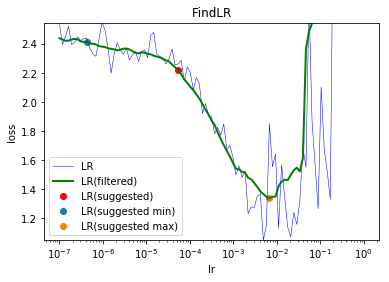

lr= 5.3703179637025284e-05, lr_min=4.265795188015926e-07, lr_max=0.0067608297539198114


In [85]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	2.09009628	1.50734267	0.24173614	0.11352454	 12.629555
1	1.27121745	0.99832364	0.09040075	0.06345804	 12.602290
2	0.88613198	0.73807043	0.06052271	0.04862555	 12.703573
3	0.71368192	1.64380047	0.05171575	0.10327595	 12.704857
4	0.59363428	0.75808011	0.04550270	0.05379463	 12.650252
5	0.55406779	0.78881937	0.04560163	0.05932387	 12.739892
6	0.49409711	0.52622647	0.04235401	0.04217469	 12.572674
7	0.38808939	0.46700899	0.03741886	0.03890830	 12.744039
8	0.33827826	0.42859204	0.03570607	0.03653841	 12.624255
9	0.33223628	0.42895590	0.03579832	0.03649016	 12.825182
i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
10	0.34266609	0.75415208	0.03612859	0.05568712	 12.574945
11	0.36470765	0.79972652	0.03715774	0.05393788	 12.743347
12	0.40734299	0.71793425	0.04095971	0.05217500	 12.714100
13	0.34859397	0.77276127	0.03749294	0.05548288	 12.660115
14	0.28680932	0.57651244	0.03737163	0.04509459	 12.751791
15	0.1823338

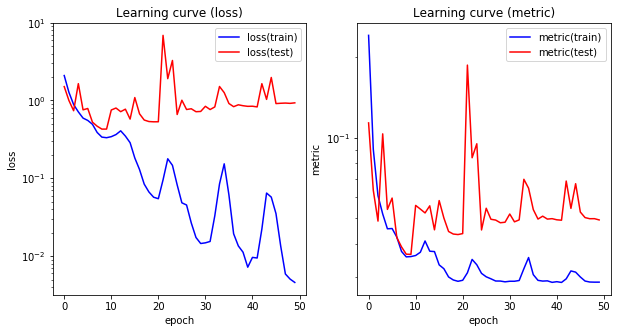

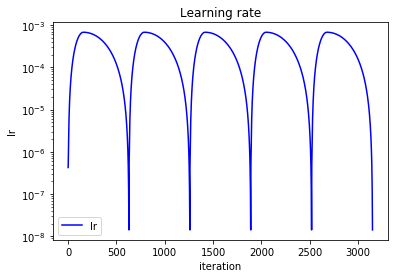

In [86]:
# lr_min/=2;
lr_max/=10
for i in range(5):
  FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
logger.Show()

## n_div=10, p_dropout=0.2

    net= TResNet18_2(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(), p_dropout=0.2)

total epochs: 50
total time: 8.17min
best loss(train): 0.004594054649628344@49
best loss(test): 0.428592037409544@8
best metric(train): 0.0286301692267732@41
best metric(test): 0.03649015724658966@9


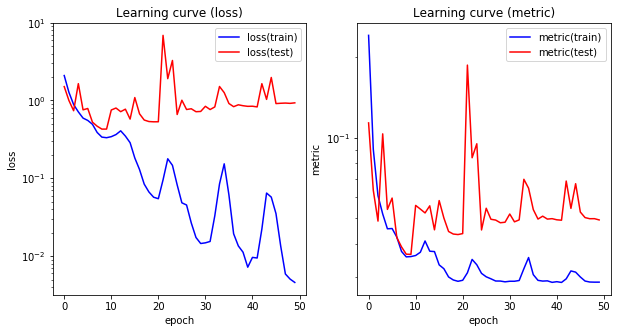

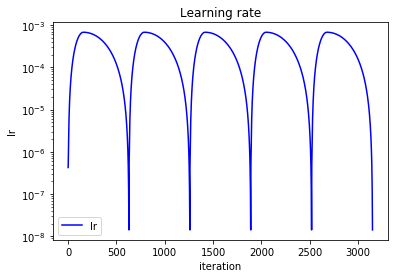

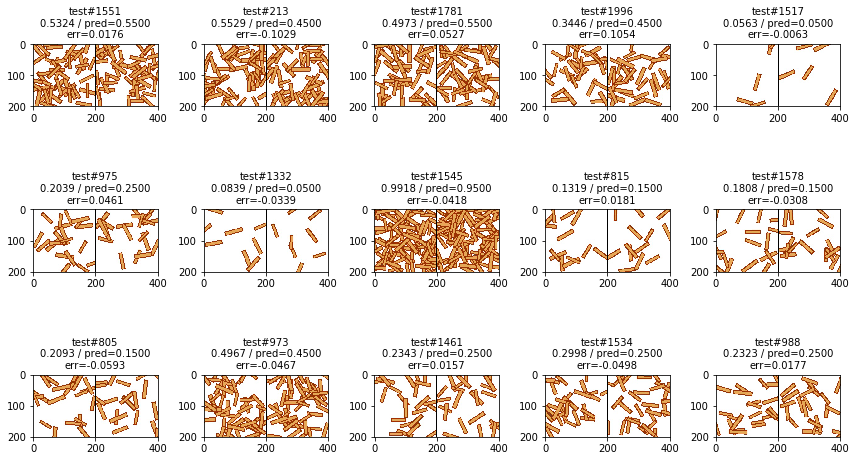

In [87]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= decode(Eval(net,(imgs,imgsr),device=device).cpu())
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

## n_div=25, p_dropout=0.2

    net= TResNet18_2(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(), p_dropout=0.2)

total epochs: 50
total time: 8.19min
best loss(train): 0.0039417109422622216@49
best loss(test): 1.2916071079671383@18
best metric(train): 0.011623495228825107@37
best metric(test): 0.03289484576089308@9


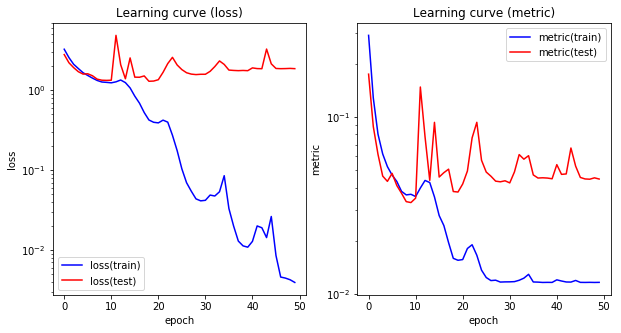

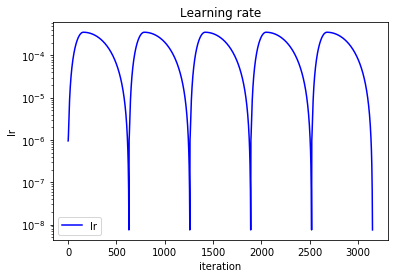

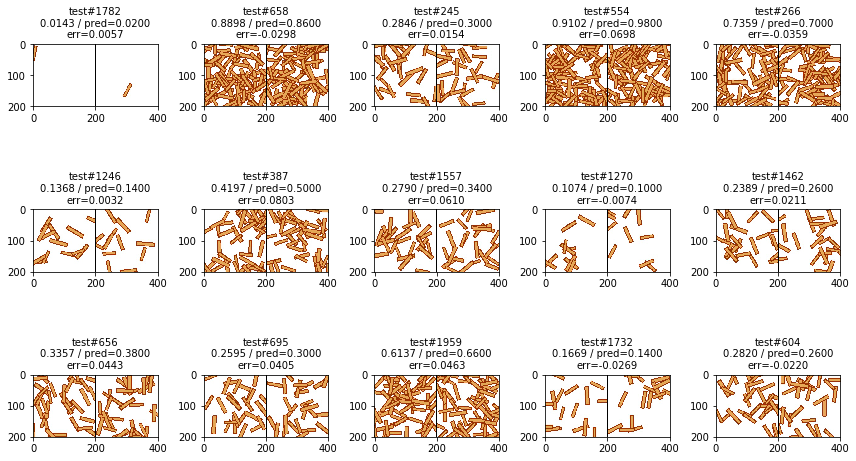

In [80]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= decode(Eval(net,(imgs,imgsr),device=device).cpu())
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)

## n_div=50, p_dropout=0.2

    net= TResNet18_2(in_imgshape=in_imgshape, out_channels=discretizer.NumClasses(), p_dropout=0.2)

total epochs: 50
total time: 8.22min
best loss(train): 0.018068242522459182@49
best loss(test): 2.1614608392119408@19
best metric(train): 0.005767050177036296@48
best metric(test): 0.0389376410166733@17


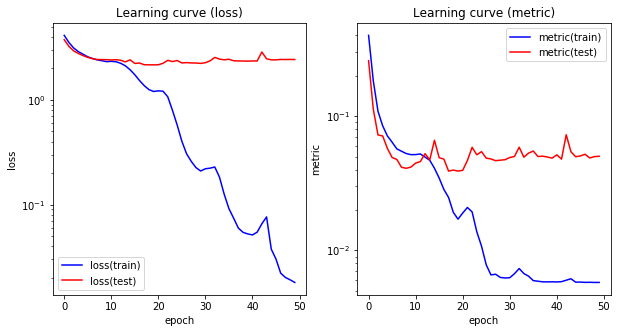

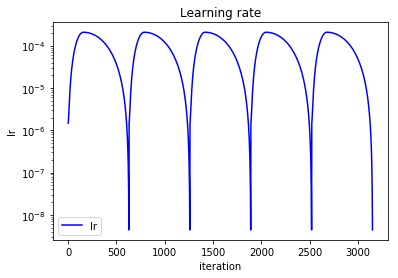

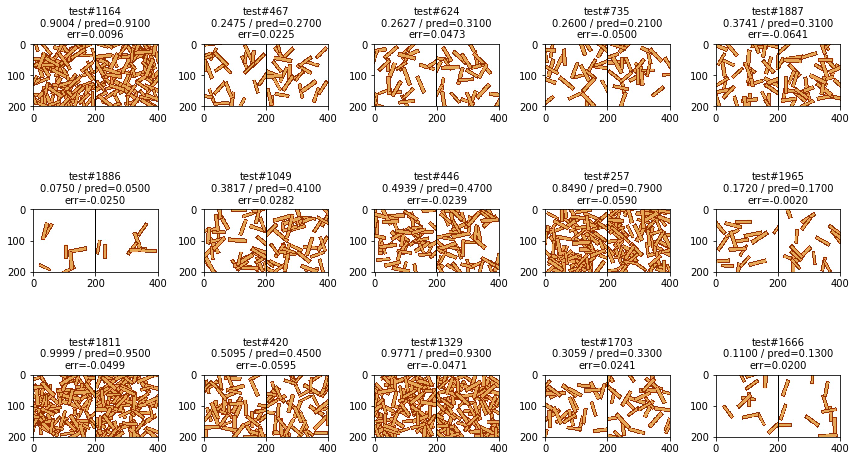

In [72]:
logger.Show('all')
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs,imgsr= [d[i][0] for i in idxes], [d[i][1] for i in idxes]
pred_y= decode(Eval(net,(imgs,imgsr),device=device).cpu())
labels= [f'test#{i}\n{d[i][2].item():.4f} / pred={lp.item():.4f}\nerr={lp.item()-d[i][2].item():.4f}' for i,lp in zip(idxes,pred_y)]
PlotImgGrid([HStackImages(img,imgr) for img,imgr in zip(imgs,imgsr)], labels)